# U1 - Abdullah Barhoum (5041774) und Katharina Müller (5284090)

# Assignment 1: Color Spaces, Morphological Operators

## Exercise 1.1

For an image of your choice, implement the simple binarization method as shown in the lecture. We've put some example images in in /images.

Rough sketch:

1. define the „positive“ subspace P in the RGB cube
2. iterate over all pixels in I and check if in P or ~P
3. write result to new image
4. play around with size and shape of P and display binary image (**RESULT**)



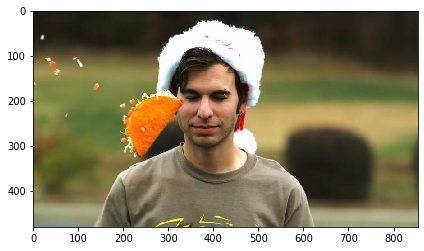

In [1]:
%matplotlib inline 
from skimage import io
from skimage.color import rgb2hsv
import numpy as np
from copy import copy, deepcopy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
from tqdm import tqdm

image = io.imread('images/taco.jpg')
io.imshow(image)

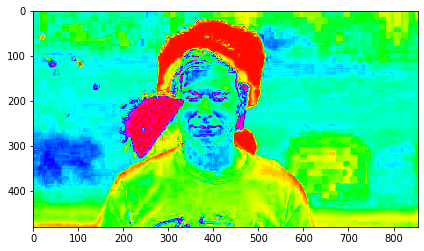

In [2]:
io.imshow(rgb2hsv(image)[:, :, 1], cmap='hsv')

In [3]:
def show_binary(im):
    plt.imshow(im, cmap='binary_r', vmin = 0, vmax = 1)

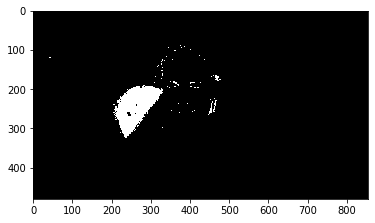

In [58]:
def extract_taco(image):
    H, W, C = image.shape
    new_img = np.zeros(H * W, np.uint8)
    for i, (h, s, v) in enumerate(rgb2hsv(image).reshape(-1, C)):
        if h  < 0.13 and s > 0.85:
            new_img[i] = 1
    return new_img.reshape(H, W)

binary_img = extract_taco(image)
show_binary(binary_img)

## Exercise 1.2

* starting from the binary color detection image
* erase noise with an erosion operation
* dilate once to get original size of object
* find connected components with one-pass algorithm
* extract bounding box on the fly
* draw bounding box on original image (**RESULT**)

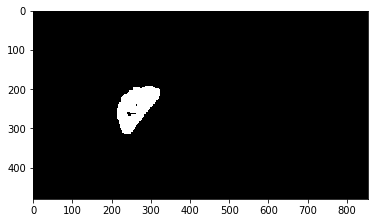

In [28]:
kernel = np.ones((15, 15), np.uint8)
def reduce_noise(image):
    image = cv2.erode(image, kernel)
    return cv2.dilate(image, kernel)
    
cleaned_binary = reduce_noise(deepcopy(binary_img))
show_binary(cleaned_binary)

[{'top_left': (214, 193), 'bottm_right': (323, 314), 'center': (261.7891784066825, 245.22229148485226)}]


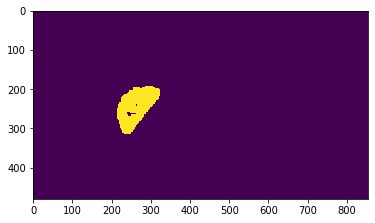

In [65]:
def show_labels(labels, num_labels):
    plt.imshow(labels, vmin=0, vmax=num_labels)


def get_shapes_and_labels(image):
    num_shapes, labels = cv2.connectedComponents(image)
    shapes = []
    # ignore the 0-th shape which is the background
    for i in range(1, num_shapes):
        xs, ys = np.where(labels == i)
        shapes.append({
            "top_left": (np.amin(ys), np.amin(xs)),
            "bottm_right": (np.amax(ys), np.amax(xs)),
            "center": (ys.mean(), xs.mean())
        })
    return shapes, labels

shapes, labels = get_shapes_and_labels(cleaned_binary)
print(shapes)
show_labels(labels, len(shapes))

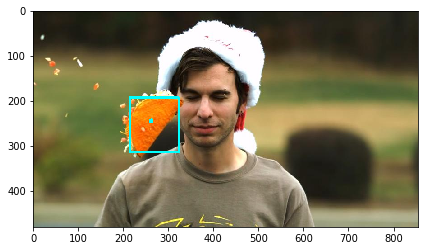

In [55]:
colors = [(0, 255, 255), (255, 255, 0), (255, 0, 255), (0, 255, 0), (0, 0, 255), (255, 0, 0)]

def round_tuple(t):
    return tuple(map(lambda x: int(round(x)), t))


def paint_shapes_on_image(shapes, image, paint_box=True, paint_center=True):
    for i, shape in enumerate(shapes):
        if paint_box:
            cv2.rectangle(image, shape['top_left'], shape['bottm_right'], colors[i], 3)
        if paint_center:
            cv2.circle(image, round_tuple(shape['center']), 5, colors[i], -1)
    return image


io.imshow(paint_shapes_on_image(shapes, deepcopy(image)))

## Exercise 1.3

* use your color detection and connected components algorithm
* implement simplest tracking algorithm
* draw history of all previous points on frame (**RESULT**)

(see images/racecar or images/taco for sample image sequences)

In [57]:
def dist_sq(p1, p2):
    return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2


def track(old_shapes, new_shapes):
    # the order is the same of the order of old_shapes:
    final = []
    for old_shape in old_shapes:
        if len(new_shapes) == 0:
            break
        distances = np.array(
            map(lambda shape: dist_sq(shape['center'], old_shape['center']),
                new_shapes))
        target_index = distances.argmin()
        final.append(new_shapes[target_index])
        new_shapes.pop(target_index)

    return final + new_shapes

In [67]:
def process_frame(image):
    binary = extract_taco(image)
    binary = reduce_noise(binary)
    shapes, _ = get_shapes_and_labels(binary)
    return shapes

shape_history = []
for i, image_path in enumerate(tqdm(glob.glob('./images/taco/*.jpg'))):
    image = io.imread(image_path)
    shapes = process_frame(image)
    if len(shape_history) > 0:
        shapes = track(shape_history[-1], shapes)
    shape_history.append(shapes)
    for shapes in shape_history[:-1]:
        paint_shapes_on_image(shapes, image, paint_box=False)
    paint_shapes_on_image(shape_history[-1], image)
    io.imsave('./output/' + str(i) +'.jpg', image)


100%|█████████████████████████████████████████| 222/222 [02:40<00:00,  1.38it/s]


In [69]:
%%HTML
<video width="854" height="480" autoplay loop>
  <source src="./images/U1/comp.mp4" type="video/mp4">
</video>